In [1]:
# Import necessary libraries
import os
import earthaccess
import shapely
import rasterio.merge
import geopandas as gpd
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from shapely.ops import unary_union
from shapely.geometry.polygon import Polygon
from cartopy.feature import ShapelyFeature
import matplotlib.patches as mpatches

# Test

In [2]:
import geopandas as gpd

wards = gpd.read_file('C:/EGM722/egm722/green_space_project/data_files/wardsPolygon.shp').to_crs(epsg=4326)


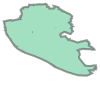

In [3]:
outline = wards['geometry'].unary_union
# gets a single polygon (or multipolygon) composed of the individual polygons


outline # note that in a jupyter notebook, this actually displays the polygon.

In [4]:
outline.bounds # get the min x, min y, max x, max y values of the polygon

(-3.008755349148092,
 53.32679003222152,
 -2.8180568159010537,
 53.474981146620536)

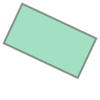

In [5]:
# gets the minimum rotated rectangle that covers the outline
search_area = outline.minimum_rotated_rectangle

search_area # again, in a jupyter notebook, this displays the polygon

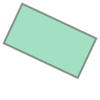

In [6]:
search_area = shapely.geometry.polygon.orient(search_area, sign=1) # a sign of 1 means oriented counter-clockwise

search_area # this doesn't actually change the geometry, just the order of the vertices

In [7]:
import earthaccess
earthaccess.login(strategy='interactive', persist=True)

In [8]:
datasets = earthaccess.search_datasets(
    keyword='elevation', # search for datasets that match the keyword 'elevation'
    polygon=search_area.exterior.coords # search for datasets that intersect Liverpool
)

Datasets found: 505


In [9]:
datasets = earthaccess.search_datasets(
    keyword='aster elevation', # search for datasets that match the keyword 'aster elevation'
    polygon=search_area.exterior.coords # search for datasets that intersect Northern Ireland
)

Datasets found: 41


In [10]:
dataset = datasets[0] # get the first result
dataset.get_umm('EntryTitle') # fill this in with the metadata field that you want

'ASTER Global Digital Elevation Model V003'

In [11]:
if datasets:
    dataset = datasets[0]  # Get the first dataset from the search results
    ds_name = dataset.get_umm('EntryTitle')  # Retrieve the full name of the dataset

    print(f"Dataset full name: {ds_name}")
else:
    print("No datasets found matching the search criteria.")


Dataset full name: ASTER Global Digital Elevation Model V003


In [12]:
ds_name = dataset.get_umm('ShortName')  # Get the short name of the dataset
results = earthaccess.search_data(
    short_name=ds_name,
    polygon=search_area.exterior.coords,
    count=10
)


Granules found: 2


In [13]:
len(results) # show the length of the results list

2

In [14]:
granule = next(iter(results)) # get the "first" item from the list
granule # show the first item

Collection: {'ShortName': 'ASTGTM', 'Version': '003'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -4.0001389, 'EastBoundingCoordinate': -2.9998611, 'NorthBoundingCoordinate': 54.0001389, 'SouthBoundingCoordinate': 52.9998611}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2000-03-01T00:00:00.000Z', 'EndingDateTime': '2013-11-30T23:59:59.000Z'}}
Size(MB): 9.44905
Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ASTGTM.003/ASTGTMV003_N53W004_dem.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ASTGTM.003/ASTGTMV003_N53W004_num.tif']

In [15]:
os.makedirs(ds_name, exist_ok=True) # create a new folder to download the granules to

In [16]:
earthaccess.login(strategy='interactive', persist=True)  #Use appropriate authentication strategy
downloaded_files = earthaccess.download(results, ds_name) # download each of the granules to the aster_gdem directory

 Getting 2 granules, approx download size: 0.03 GB


QUEUEING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

File ASTGTMV003_N53W004_dem.tif already downloaded
File ASTGTMV003_N53W004_num.tif already downloaded
File ASTGTMV003_N53W003_dem.tif already downloaded
File ASTGTMV003_N53W003_num.tif already downloaded


PROCESSING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/4 [00:00<?, ?it/s]

In [17]:
dem_files = [fn for fn in downloaded_files if 'dem.tif' in fn] # use list comprehension to select only filenames that match '*dem.tif'

print(dem_files) # confirm that this has worked

['ASTGTM\\ASTGTMV003_N53W004_dem.tif', 'ASTGTM\\ASTGTMV003_N53W003_dem.tif']


In [18]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from cartopy.feature import ShapelyFeature
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

plt.ion()  # make the plotting interactive

# Load the Liverpool data
liverpool_wards = gpd.read_file('C:/EGM722/egm722/green_space_project/data_files/WardsPolygon.shp', crs='EPSG:4326')
liverpool_water = gpd.read_file('C:/EGM722/egm722/green_space_project/data_files/Water_liverpool.shp', crs='EPSG:4326')
liverpool_landuse = gpd.read_file('C:/EGM722/egm722/green_space_project/data_files/Landuse_liverpool.shp', crs='EPSG:4326')

# Define the CRS directly as EPSG:4327
liverpool_crs = ccrs.epsg(4327)

# Create a figure and axes
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=liverpool_crs)

# Add Liverpool wards
for ward_name in liverpool_wards['wardname']:
    feat = ShapelyFeature(liverpool_wards[liverpool_wards['wardname'] == ward_name]['geometry'],
                          liverpool_crs, edgecolor='k', facecolor='lightblue', linewidth=1, alpha=0.5)
    ax.add_feature(feat)

# Add Liverpool water bodies
water_feat = ShapelyFeature(liverpool_water['geometry'], liverpool_crs, edgecolor='blue', facecolor='blue', linewidth=1)
ax.add_feature(water_feat)

# Add Liverpool land use
landuse_feat = ShapelyFeature(liverpool_landuse['geometry'], liverpool_crs, edgecolor='green', facecolor='green', linewidth=1)
ax.add_feature(landuse_feat)

# Add legend
county_handles = [mpatches.Patch(color='lightblue', label='Wards'),
                  mpatches.Patch(color='blue', label='Water Bodies'),
                  mpatches.Patch(color='green', label='Land Use')]
ax.legend(handles=county_handles, loc='upper left')

plt.show()


ValueError: EPSG code does not define a projection

In [ ]:
print(liverpool_wards.columns)


ValueError: Axis limits cannot be NaN or Inf

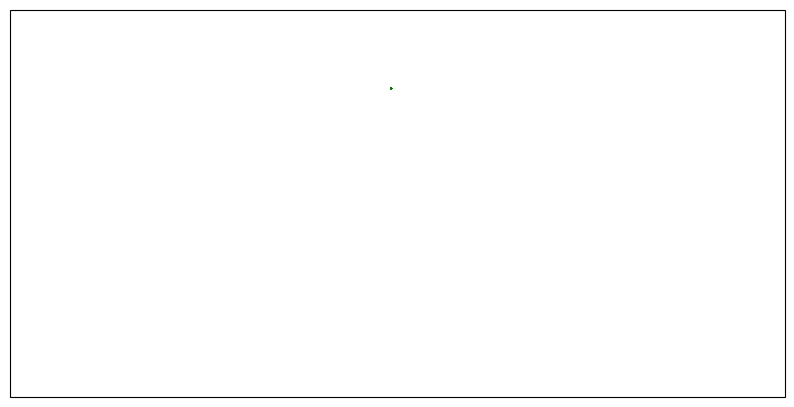

In [19]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from cartopy.feature import ShapelyFeature
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

plt.ion()  # make the plotting interactive

# Load the Liverpool data
liverpool_wards = gpd.read_file('C:/EGM722/egm722/green_space_project/data_files/WardsPolygon.shp', crs='EPSG:4326')
liverpool_water = gpd.read_file('C:/EGM722/egm722/green_space_project/data_files/Water_liverpool.shp', crs='EPSG:4326')
liverpool_landuse = gpd.read_file('C:/EGM722/egm722/green_space_project/data_files/Landuse_liverpool.shp', crs='EPSG:4326')

# Create the PlateCarree projection for Liverpool (geographic coordinates)
liverpool_crs = ccrs.PlateCarree()

# Create a figure and axes
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=liverpool_crs)

# Add Liverpool wards
for ward_name in liverpool_wards['wardname']:
    feat = ShapelyFeature(liverpool_wards[liverpool_wards['wardname'] == ward_name]['geometry'],
                          liverpool_crs, edgecolor='k', facecolor='lightblue', linewidth=1, alpha=0.5)
    ax.add_feature(feat)

# Add Liverpool water bodies
water_feat = ShapelyFeature(liverpool_water['geometry'], liverpool_crs, edgecolor='blue', facecolor='blue', linewidth=1)
ax.add_feature(water_feat)

# Add Liverpool land use
landuse_feat = ShapelyFeature(liverpool_landuse['geometry'], liverpool_crs, edgecolor='green', facecolor='green', linewidth=1)
ax.add_feature(landuse_feat)

# Set extent
minx, miny, maxx, maxy = liverpool_wards.total_bounds
ax.set_extent([minx, maxx, miny, maxy], crs=liverpool_crs)

# Add legend
county_handles = [mpatches.Patch(color='lightblue', label='Wards'),
                  mpatches.Patch(color='blue', label='Water Bodies'),
                  mpatches.Patch(color='green', label='Land Use')]
ax.legend(handles=county_handles, loc='upper left')

plt.show()


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

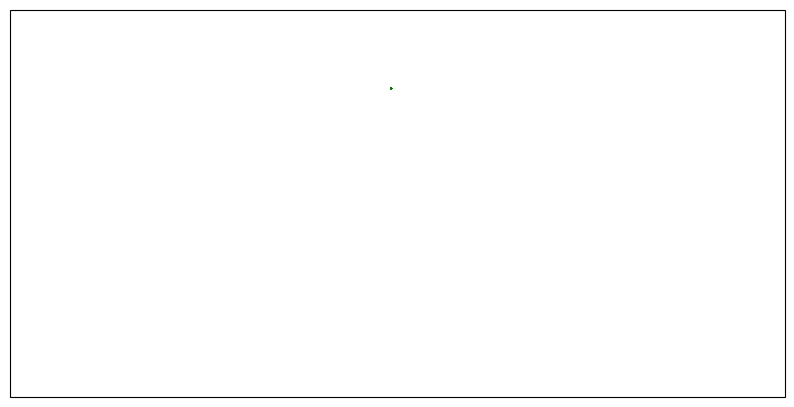

In [20]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from cartopy.feature import ShapelyFeature
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

plt.ion()  # make the plotting interactive

# Load the Liverpool data
liverpool_wards = gpd.read_file('C:/EGM722/egm722/green_space_project/data_files/WardsPolygon.shp', crs='EPSG:4326')
liverpool_water = gpd.read_file('C:/EGM722/egm722/green_space_project/data_files/Water_liverpool.shp', crs='EPSG:4326')
liverpool_landuse = gpd.read_file('C:/EGM722/egm722/green_space_project/data_files/Landuse_liverpool.shp', crs='EPSG:4326')

# Define the CRS directly as EPSG:4326
liverpool_crs = ccrs.PlateCarree()

# Create a figure and axes
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=liverpool_crs)

# Add Liverpool wards
for ward_name in liverpool_wards['wardname']:
    feat = ShapelyFeature(liverpool_wards[liverpool_wards['wardname'] == ward_name]['geometry'],
                          liverpool_crs, edgecolor='k', facecolor='lightblue', linewidth=1, alpha=0.5)
    ax.add_feature(feat)

# Add Liverpool water bodies
water_feat = ShapelyFeature(liverpool_water['geometry'], liverpool_crs, edgecolor='blue', facecolor='blue', linewidth=1)
ax.add_feature(water_feat)

# Add Liverpool land use
landuse_feat = ShapelyFeature(liverpool_landuse['geometry'], liverpool_crs, edgecolor='green', facecolor='green', linewidth=1)
ax.add_feature(landuse_feat)

# Check for NaN or Inf values in the bounds
if liverpool_wards.isnull().values.any() or not liverpool_wards.total_bounds:
    print("Error: NaN or Inf values detected in the bounds. Unable to set extent.")
else:
    # Set extent
    minx, miny, maxx, maxy = liverpool_wards.total_bounds
    ax.set_extent([minx, maxx, miny, maxy], crs=liverpool_crs)

# Add legend
county_handles = [mpatches.Patch(color='lightblue', label='Wards'),
                  mpatches.Patch(color='blue', label='Water Bodies'),
                  mpatches.Patch(color='green', label='Land Use')]
ax.legend(handles=county_handles, loc='upper left')

plt.show()


In [ ]:
liverpool_wards.head(5) # show the first 5 rows of the table

In [ ]:
# New Practice

In [21]:
# allows the figure to be interactive
%matplotlib inline

#import libraries
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from cartopy.feature import ShapelyFeature
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# make plotting interactive 
plt.ion() 

In [22]:
# generate matplotlib handles to create a legend of each of the features we put in our map.
def generate_handles(labels, colors, edge='k', alpha=1):
    lc = len(colors)  # get the length of the color list
    handles = [] # create an empty list
    for ii in range(len(labels)): # for each label and color pair that we're given, make an empty box to pass to our legend
        handles.append(mpatches.Rectangle((0, 0), 1, 1, facecolor=colors[ii % lc], edgecolor=edge, alpha=alpha))
    return handles

# create a scale bar of length 20 km in the upper right corner of the map
# adapted this question: https://stackoverflow.com/q/32333870
# answered by SO user Siyh: https://stackoverflow.com/a/35705477
def scale_bar(ax, location=(0.92, 0.95)):
    x0, x1, y0, y1 = ax.get_extent() # get the current extent of the axis
    sbx = x0 + (x1 - x0) * location[0] # get the lower left x coordinate of the scale bar
    sby = y0 + (y1 - y0) * location[1] # get the lower left y coordinate of the scale bar

    ax.plot([sbx, sbx - 20000], [sby, sby], color='k', linewidth=9, transform=ax.projection) # plot a thick black line, 20 km long
    ax.plot([sbx, sbx - 10000], [sby, sby], color='k', linewidth=6, transform=ax.projection) # plot a smaller black line from 0 to 10 km long
    ax.plot([sbx-10000, sbx - 20000], [sby, sby], color='w', linewidth=6, transform=ax.projection) # plot a white line from 10 to 20 km

    ax.text(sbx, sby-5000, '20 km', transform=ax.projection, fontsize=8) # add a label at 20 km
    ax.text(sbx-12500, sby-5000, '10 km', transform=ax.projection, fontsize=8) # add a label at 10 km
    ax.text(sbx-24500, sby-5000, '0 km', transform=ax.projection, fontsize=8) # add a label at 0 km

    return ax

In [ ]:
# Load the Liverpool data
liverpool_wards = gpd.read_file('C:/EGM722/egm722/green_space_project/data_files/wards.shp', crs='EPSG:4326')
liverpool_water = gpd.read_file('C:/EGM722/egm722/green_space_project/data_files/Water_liverpool.shp', crs='EPSG:4326')
liverpool_landuse = gpd.read_file('C:/EGM722/egm722/green_space_project/data_files/Landuse_liverpool.shp', crs='EPSG:4326')

In [ ]:
liverpool_wards.head(10)

In [ ]:
liverpool_wards.crs # show the CRS of the wards dataset

In [ ]:
ni_utm = ccrs.UTM(30)  # create a Universal Transverse Mercator reference system to transform our data.
# 30 is the UTM zone that Liverpool falls in

In [ ]:
ccrs.CRS(liverpool_wards.crs) # create a cartopy CRS representation of the CRS associated with the outline dataset

In [ ]:
myFig = plt.figure(figsize=(8, 8))  # create a figure of size 8x8 (representing the page size in inches)
ax = plt.axes(projection=ni_utm)  # create an axes object in the figure, using a UTM projection,
# where we can actually plot our data.

In [ ]:
# first, we just add the outline of Northern Ireland using cartopy's ShapelyFeature
wards_feature = ShapelyFeature(liverpool_wards['geometry'], ni_utm, edgecolor='k', facecolor='w')
ax.add_feature(wards_feature) # add the features we've created to the map.

myFig

In [ ]:
xmin, ymin, xmax, ymax = liverpool_wards.total_bounds # using the boundary of the shapefile features, zoom the map to our area of interest
ax.set_extent([xmin-5000, xmax+5000, ymin-5000, ymax+5000], crs=ni_utm) # because total_bounds gives output as xmin, ymin, xmax, ymax,
# but set_extent takes xmin, xmax, ymin, ymax, we re-order the coordinates here.

myFig ## re-draw the figure (only for the notebook)

In [24]:
water_feat = ShapelyFeature(liverpool_water['geometry'], # first argument is the geometry
                            ccrs.CRS(liverpool_water.crs), # second argument is the CRS
                            edgecolor='royalblue', # set the edgecolor to be royalblue
                            linewidth=0.2) # set the linewidth to be 0.2 pt
ax.add_feature(water_feat) # add the collection of features to the map

Fig # to show the updated figure

NameError: name 'Fig' is not defined

In [ ]:
water_feat = ShapelyFeature(liverpool_water_proj['geometry'], # first argument is the geometry
                            ccrs.CRS(liverpool_water.crs), # second argument is the CRS
                            edgecolor='royalblue', # set the edgecolor to be royalblue
                            linewidth=0.2) # set the linewidth to be 0.2 pt
ax.add_feature(water_feat) # add the collection of features to the map

myFig # to show the updated figure